# Option Pricing with BasePricer and MCPricer

This notebook demonstrates how to use the `BasePricer` and `MCPricer` classes to price options with different volatility models, including:
1. Local volatility models
2. Path-dependent volatility (PDV) models

We'll walk through setting up the models, configuring the pricers, and calculating option prices and Greeks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from typing import Callable, Dict, List, Tuple

# Import our pricer and model classes
from base_model import BaseModel
from BasePricer import BasePricer
from MCPricer import MCPricer
from pdv_model import PDVModel

## 1. Creating a Simple Local Volatility Model

First, let's create a simple local volatility model by extending the `BaseModel` class. This will serve as our foundation for option pricing.

In [2]:
class LocalVolModel(BaseModel):
    """
    A simple local volatility model where volatility depends on spot price and time.
    """
    
    def __init__(
            self, 
            s0: float,
            x0: float = 0.2,  # Initial volatility level
            vol_surface: Callable = None,
            skew_factor: float = -0.4,  # Negative for downward skew
            term_structure: List[Tuple[float, float]] = None
        ):
        """
        Initialize the local volatility model.
        
        Args:
            s0: Initial spot price
            x0: Initial factor value (not used in this model but needed for BaseModel)
            vol_surface: Callable taking (t, S) and returning volatility
            skew_factor: Controls the skew in the volatility smile
            term_structure: List of (time, vol) pairs to define term structure
        """
        super().__init__(s0, x0)
        
        self.skew_factor = skew_factor
        
        # If a volatility surface function is provided, use it
        if vol_surface is not None:
            self.vol_surface = vol_surface
        else:
            # Default volatility surface: smile with term structure
            if term_structure is None:
                # Default flat term structure
                term_structure = [(0.0, 0.2), (1.0, 0.2), (2.0, 0.2)]
            
            # Create interpolator for term structure
            times = [t for t, _ in term_structure]
            vols = [v for _, v in term_structure]
            self.term_structure_interp = interp1d(
                times, vols, kind='linear', fill_value='extrapolate'
            )
    
    def sigma(self, t: float, S: np.ndarray, X: np.ndarray) -> np.ndarray:
        """
        Calculate volatility at time t for spot price S and factor X.
        
        Args:
            t: Time
            S: Spot price array
            X: Factor array (not used in this model)
            
        Returns:
            Volatility array
        """
        if hasattr(self, 'vol_surface'):
            # Use custom volatility surface if provided
            return self.vol_surface(t, S)
        else:
            # Default vol: base level from term structure with skew based on moneyness
            base_vol = self.term_structure_interp(t)
            moneyness = S / self.s0 - 1.0  # (S/S0 - 1)
            return base_vol * (1.0 + self.skew_factor * moneyness)
    
    def dupire_vol(self, t: float, S: np.ndarray) -> np.ndarray:
        """
        Get Dupire local volatility.
        For our simple model, this is the same as sigma.
        
        Args:
            t: Time
            S: Spot price array
            
        Returns:
            Dupire volatility array
        """
        # For this simple model, we use the same function as sigma
        dummy_x = np.zeros_like(S)
        return self.sigma(t, S, dummy_x)
    
    def update_X(self, t: float) -> np.ndarray:
        """
        Update the factor X (not used in local vol model, but needed for BaseModel).
        
        Args:
            t: Time
            
        Returns:
            Updated factor array
        """
        # Local vol model doesn't use X, so we just return the initial value
        num_particles = self.pathS.shape[0]
        return np.full(num_particles, self.x0)

# Create a model instance with a skewed volatility surface
s0 = 100.0  # Initial spot price
skew = -0.5  # Negative skew (common in equity markets)

# Term structure with increasing volatility
term_structure = [
    (0.0, 0.15),   # Very short term
    (0.25, 0.18),  # 3 months
    (0.5, 0.20),   # 6 months
    (1.0, 0.22),   # 1 year
    (2.0, 0.25)    # 2 years
]

# Create the model
local_vol_model = LocalVolModel(
    s0=s0,
    skew_factor=skew,
    term_structure=term_structure
)

print(f"Model initialized with:")
print(f"  - Initial spot price: {s0}")
print(f"  - Volatility skew factor: {skew}")
print(f"  - Term structure: {term_structure}")

Model initialized with:
  - Initial spot price: 100.0
  - Volatility skew factor: -0.5
  - Term structure: [(0.0, 0.15), (0.25, 0.18), (0.5, 0.2), (1.0, 0.22), (2.0, 0.25)]


### 1.1 Visualizing the Volatility Surface

Let's visualize the volatility surface of our local volatility model to understand how it varies with time and spot price.

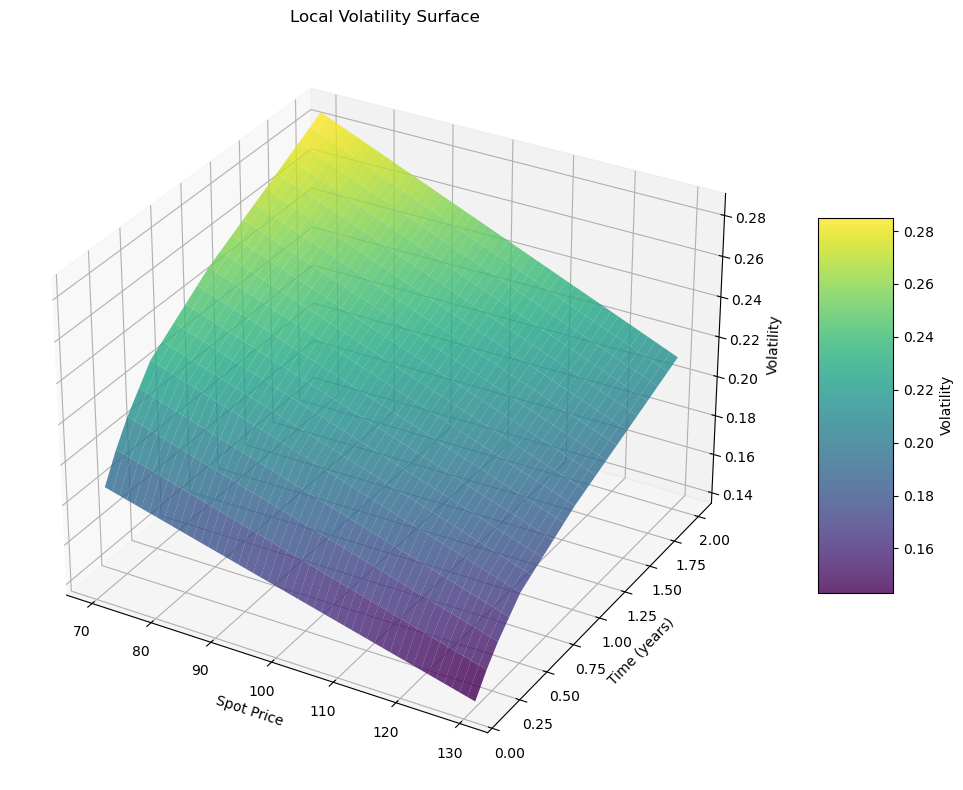

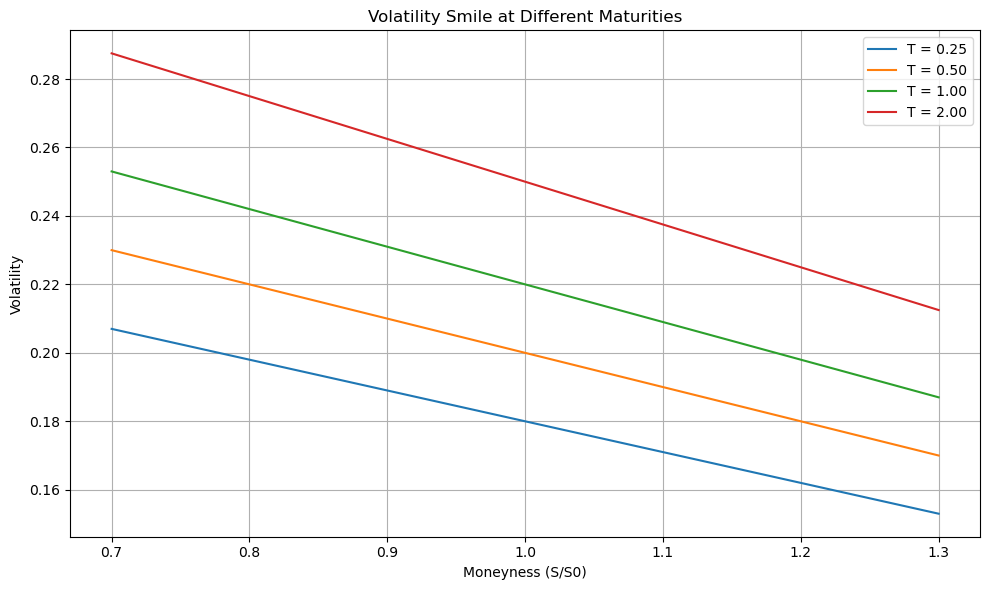

In [3]:
# Create a grid of spot prices and times
spot_prices = np.linspace(70, 130, 50)  # From 70 to 130
times = np.linspace(0.1, 2.0, 20)       # From 0.1 to 2 years

# Create meshgrid for 3D surface plot
S_grid, T_grid = np.meshgrid(spot_prices, times)
vols = np.zeros_like(S_grid)

# Calculate volatilities for each point in the grid
for i in range(len(times)):
    for j in range(len(spot_prices)):
        t = times[i]
        s = spot_prices[j]
        # Get volatility at this point (with dummy X)
        vols[i, j] = local_vol_model.sigma(t, np.array([s]), np.array([0]))[0]

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_grid, T_grid, vols, cmap='viridis', alpha=0.8)

# Add labels and colorbar
ax.set_xlabel('Spot Price')
ax.set_ylabel('Time (years)')
ax.set_zlabel('Volatility')
ax.set_title('Local Volatility Surface')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Volatility')

plt.tight_layout()
plt.show()

# Let's also plot volatility smiles at different maturities
plt.figure(figsize=(10, 6))

# Select a few maturities
selected_times = [0.25, 0.5, 1.0, 2.0]
for t in selected_times:
    vols_at_t = [local_vol_model.sigma(t, np.array([s]), np.array([0]))[0] for s in spot_prices]
    plt.plot(spot_prices/s0, vols_at_t, label=f'T = {t:.2f}')

plt.xlabel('Moneyness (S/S0)')
plt.ylabel('Volatility')
plt.title('Volatility Smile at Different Maturities')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Setting Up the Monte Carlo Pricer

Now let's set up the Monte Carlo pricer using our local volatility model. We'll configure:
1. Number of paths
2. Time steps
3. Risk-free rate and dividend yield

In [4]:
# Set up the Monte Carlo pricer with our local volatility model
mc_pricer = MCPricer(
    model=local_vol_model,
    risk_free_rate=0.03,     # 3% risk-free rate
    dividend_yield=0.01,     # 1% dividend yield
    use_antithetic=True,     # Use antithetic variates for variance reduction
    use_sobol=False          # Use pseudo-random numbers (not Sobol sequences)
)

# Configure the simulation parameters
mc_pricer.setup_simulation(
    num_paths=10000,     # 10,000 paths (will be 20,000 with antithetic variates)
    time_steps=252,      # Daily steps (252 trading days in a year)
    dt=1/252,            # Time step size (daily)
    bins=200,            # Number of bins for discretizing the stock price
    method='bin'         # Method for computing conditional expectation
)

print("Monte Carlo pricer configured with:")
print(f"  - Model: {mc_pricer.model.__class__.__name__}")
print(f"  - Risk-free rate: {mc_pricer.risk_free_rate:.1%}")
print(f"  - Dividend yield: {mc_pricer.dividend_yield:.1%}")
print(f"  - Number of paths: {mc_pricer.num_paths:,d} ({mc_pricer.num_paths*2:,d} with antithetic)")
print(f"  - Time steps: {mc_pricer.time_steps:d} (daily)")

# Run the simulation to generate paths
paths, path_x = mc_pricer.run_simulation()
print(f"Generated {paths.shape[0]:,d} paths of length {paths.shape[1]:d}")

Monte Carlo pricer configured with:
  - Model: LocalVolModel
  - Risk-free rate: 3.0%
  - Dividend yield: 1.0%
  - Number of paths: 10,000 (20,000 with antithetic)
  - Time steps: 252 (daily)
Generated 20,000 paths of length 253
Generated 20,000 paths of length 253


### 2.1 Visualizing the Simulated Paths

Let's visualize some of the simulated paths to see how they evolve with our local volatility model.

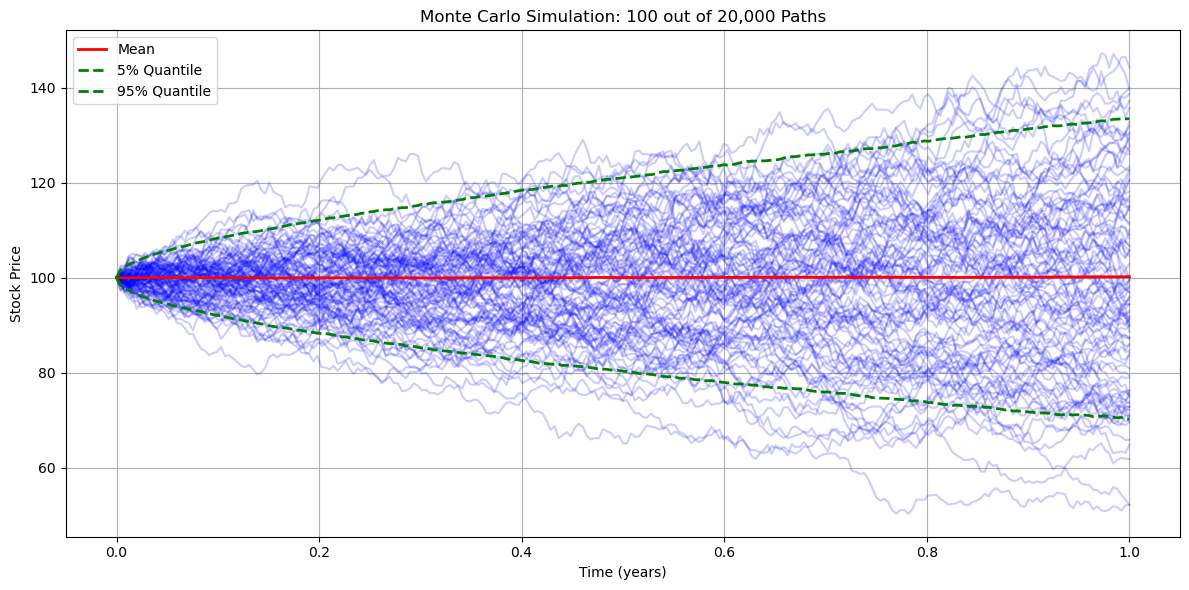

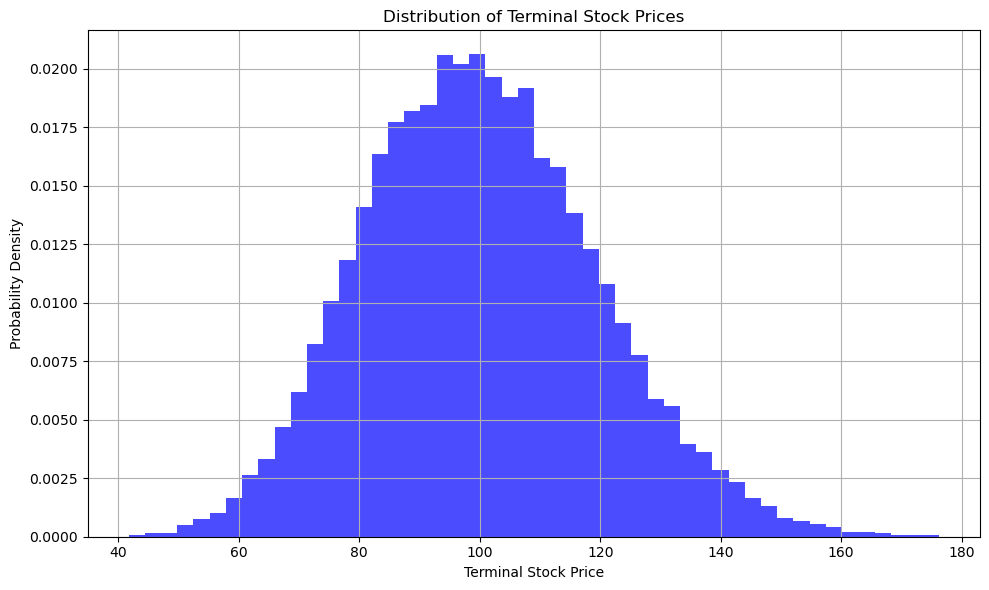

In [5]:
# Plot a sample of the simulated paths
plt.figure(figsize=(12, 6))

# Number of paths to display
num_display_paths = 100
num_total_paths = paths.shape[0]

# Randomly select paths to display
rng = np.random.RandomState(42)  # For reproducibility
selected_indices = rng.choice(num_total_paths, size=num_display_paths, replace=False)

# Time grid (in years)
time_grid = np.linspace(0, mc_pricer.time_steps * mc_pricer.dt, mc_pricer.time_steps + 1)

# Plot selected paths
for idx in selected_indices:
    plt.plot(time_grid, paths[idx], alpha=0.2, color='blue')

# Add mean path
mean_path = np.mean(paths, axis=0)
plt.plot(time_grid, mean_path, color='red', linewidth=2, label='Mean')

# Add confidence intervals
quantile_05 = np.quantile(paths, 0.05, axis=0)
quantile_95 = np.quantile(paths, 0.95, axis=0)
plt.plot(time_grid, quantile_05, color='green', linewidth=2, linestyle='--', label='5% Quantile')
plt.plot(time_grid, quantile_95, color='green', linewidth=2, linestyle='--', label='95% Quantile')

# Add labels and title
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.title(f'Monte Carlo Simulation: {num_display_paths} out of {num_total_paths:,d} Paths')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histogram of terminal prices
plt.figure(figsize=(10, 6))
terminal_prices = paths[:, -1]
plt.hist(terminal_prices, bins=50, alpha=0.7, color='blue', density=True)
plt.xlabel('Terminal Stock Price')
plt.ylabel('Probability Density')
plt.title('Distribution of Terminal Stock Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Pricing European Options

Let's use our Monte Carlo pricer to price European call and put options with different strikes and maturities.

In [6]:
# Define option parameters
strikes = [90, 95, 100, 105, 110]  # Different strike prices
expiries = [0.25, 0.5, 1.0]        # Different maturities (in years)

# Create tables to store results
results_call = []
results_put = []

# Price options for each combination of strike and expiry
for expiry in expiries:
    for strike in strikes:
        # Price call option
        call_result = mc_pricer.price('call', strike, expiry)
        
        # Price put option
        put_result = mc_pricer.price('put', strike, expiry)
        
        # Store results
        results_call.append({
            'Expiry': expiry,
            'Strike': strike,
            'Price': call_result['price'],
            'Std Error': call_result['std_error'],
            'Conf Interval Low': call_result['conf_interval_95'][0],
            'Conf Interval High': call_result['conf_interval_95'][1]
        })
        
        results_put.append({
            'Expiry': expiry,
            'Strike': strike,
            'Price': put_result['price'],
            'Std Error': put_result['std_error'],
            'Conf Interval Low': put_result['conf_interval_95'][0],
            'Conf Interval High': put_result['conf_interval_95'][1]
        })

# Convert results to DataFrames
df_call = pd.DataFrame(results_call)
df_put = pd.DataFrame(results_put)

# Display results
print("European Call Option Prices:")
print(df_call)
print("\nEuropean Put Option Prices:")
print(df_put)

European Call Option Prices:
    Expiry  Strike      Price  Std Error  Conf Interval Low  \
0     0.25      90  10.278589   0.052632          10.175430   
1     0.25      95   6.239853   0.045183           6.151295   
2     0.25     100   3.221207   0.034211           3.154154   
3     0.25     105   1.369149   0.022412           1.325222   
4     0.25     110   0.469889   0.012668           0.445059   
5     0.50      90  11.244693   0.072740          11.102123   
6     0.50      95   7.699356   0.063341           7.575208   
7     0.50     100   4.897568   0.052025           4.795600   
8     0.50     105   2.877529   0.040093           2.798946   
9     0.50     110   1.539723   0.028987           1.482909   
10    1.00      90  13.304176   0.103271          13.101764   
11    1.00      95  10.203953   0.092869          10.021929   
12    1.00     100   7.592535   0.081553           7.432692   
13    1.00     105   5.472525   0.069895           5.335531   
14    1.00     110   3.817

### 3.1 Calculating Option Greeks

Let's calculate the Delta and Gamma for our options using the bump-and-revalue method.

In [7]:
# Select a subset of options for Greek calculation
selected_strikes = [90, 100, 110]
selected_expiries = [0.5]

# Create tables to store Greeks results
greek_results = []

# Calculate Greeks for selected options
for expiry in selected_expiries:
    for strike in selected_strikes:
        # Calculate Greeks for call option
        call_greeks = mc_pricer.calc_greeks('call', strike, expiry)
        
        # Calculate Greeks for put option
        put_greeks = mc_pricer.calc_greeks('put', strike, expiry)
        
        # Store results
        greek_results.append({
            'Option Type': 'Call',
            'Expiry': expiry,
            'Strike': strike,
            'Price': call_greeks['price'],
            'Delta': call_greeks['delta'],
            'Gamma': call_greeks['gamma']
        })
        
        greek_results.append({
            'Option Type': 'Put',
            'Expiry': expiry,
            'Strike': strike,
            'Price': put_greeks['price'],
            'Delta': put_greeks['delta'],
            'Gamma': put_greeks['gamma']
        })

# Convert results to DataFrame
df_greeks = pd.DataFrame(greek_results)

# Display results
print("Option Greeks:")
print(df_greeks)

Option Greeks:
  Option Type  Expiry  Strike      Price  Delta  Gamma
0        Call     0.5      90  11.244693    0.0    0.0
1         Put     0.5      90   1.364539    0.0    0.0
2        Call     0.5     100   4.897568    0.0    0.0
3         Put     0.5     100   4.868533    0.0    0.0
4        Call     0.5     110   1.539723    0.0    0.0
5         Put     0.5     110  11.361807    0.0    0.0


## 4. Pricing Exotic Options

Our Monte Carlo pricer can also handle exotic options like barrier options and Asian options. Let's price some of these.

In [8]:
# Define barrier option parameters
barrier_strike = 100
barrier_expiry = 1.0

# Define different barrier types and levels
barrier_types = ['up-and-out', 'down-and-out', 'up-and-in', 'down-and-in']
barrier_levels = {
    'up-and-out': 120,    # Barrier above spot
    'down-and-out': 80,   # Barrier below spot
    'up-and-in': 120,     # Barrier above spot
    'down-and-in': 80     # Barrier below spot
}

# Create table to store barrier option results
barrier_results = []

# Price barrier options
for barrier_type in barrier_types:
    barrier_level = barrier_levels[barrier_type]
    
    # Price call barrier option
    call_result = mc_pricer.price_barrier_option(
        'call', barrier_type, barrier_strike, barrier_level, barrier_expiry
    )
    
    # Price put barrier option
    put_result = mc_pricer.price_barrier_option(
        'put', barrier_type, barrier_strike, barrier_level, barrier_expiry
    )
    
    # Store results
    barrier_results.append({
        'Option Type': 'Call',
        'Barrier Type': barrier_type,
        'Barrier Level': barrier_level,
        'Strike': barrier_strike,
        'Expiry': barrier_expiry,
        'Price': call_result['price'],
        'Std Error': call_result['std_error']
    })
    
    barrier_results.append({
        'Option Type': 'Put',
        'Barrier Type': barrier_type,
        'Barrier Level': barrier_level,
        'Strike': barrier_strike,
        'Expiry': barrier_expiry,
        'Price': put_result['price'],
        'Std Error': put_result['std_error']
    })

# Convert results to DataFrame
df_barrier = pd.DataFrame(barrier_results)

# Display results
print("Barrier Option Prices:")
print(df_barrier)

Barrier Option Prices:
  Option Type  Barrier Type  Barrier Level  Strike  Expiry     Price  \
0        Call    up-and-out            120     100     1.0  1.484460   
1         Put    up-and-out            120     100     1.0  7.251167   
2        Call  down-and-out             80     100     1.0  7.496550   
3         Put  down-and-out             80     100     1.0  1.914968   
4        Call     up-and-in            120     100     1.0  6.108075   
5         Put     up-and-in            120     100     1.0  0.132679   
6        Call   down-and-in             80     100     1.0  0.095985   
7         Put   down-and-in             80     100     1.0  5.468879   

   Std Error  
0   0.025659  
1   0.072585  
2   0.081606  
3   0.029008  
4   0.083061  
5   0.008777  
6   0.007960  
7   0.073860  


### 4.1 Pricing Asian Options

Let's also price Asian options, which depend on the average price of the underlying over a period.

In [9]:
# Define Asian option parameters
asian_strike = 100
asian_expiry = 1.0

# Define different configurations for Asian options
averaging_types = ['arithmetic', 'geometric']
averaging_freqs = ['daily', 'weekly', 'monthly']

# Create table to store Asian option results
asian_results = []

# Price Asian options
for avg_type in averaging_types:
    for avg_freq in averaging_freqs:
        # Price call Asian option
        call_result = mc_pricer.price_asian_option(
            'call', asian_strike, asian_expiry, avg_type, avg_freq
        )
        
        # Price put Asian option
        put_result = mc_pricer.price_asian_option(
            'put', asian_strike, asian_expiry, avg_type, avg_freq
        )
        
        # Store results
        asian_results.append({
            'Option Type': 'Call',
            'Averaging Type': avg_type,
            'Averaging Frequency': avg_freq,
            'Strike': asian_strike,
            'Expiry': asian_expiry,
            'Price': call_result['price'],
            'Std Error': call_result['std_error']
        })
        
        asian_results.append({
            'Option Type': 'Put',
            'Averaging Type': avg_type,
            'Averaging Frequency': avg_freq,
            'Strike': asian_strike,
            'Expiry': asian_expiry,
            'Price': put_result['price'],
            'Std Error': put_result['std_error']
        })

# Convert results to DataFrame
df_asian = pd.DataFrame(asian_results)

# Display results
print("Asian Option Prices:")
print(df_asian)

Asian Option Prices:
   Option Type Averaging Type Averaging Frequency  Strike  Expiry  \
0         Call     arithmetic               daily     100     1.0   
1          Put     arithmetic               daily     100     1.0   
2         Call     arithmetic              weekly     100     1.0   
3          Put     arithmetic              weekly     100     1.0   
4         Call     arithmetic             monthly     100     1.0   
5          Put     arithmetic             monthly     100     1.0   
6         Call      geometric               daily     100     1.0   
7          Put      geometric               daily     100     1.0   
8         Call      geometric              weekly     100     1.0   
9          Put      geometric              weekly     100     1.0   
10        Call      geometric             monthly     100     1.0   
11         Put      geometric             monthly     100     1.0   

           Price     Std Error  
0   3.927059e+00  4.186550e-02  
1   3.885528e+0

## 5. Using the Path-Dependent Volatility (PDV) Model

Finally, let's see how to use the PDV model with our pricing framework. The PDV model captures path-dependent volatility effects.

In [10]:
# Create a simple function for Dupire volatility interpolation
def dupire_vol_interp(t, S):
    """Simple Dupire volatility interpolation function"""
    base_vol = 0.2
    skew = -0.4
    term_factor = 1.0 + 0.1 * t  # Slight increase with time
    moneyness = S / s0 - 1.0
    return base_vol * term_factor * (1.0 + skew * moneyness)

# Create a PDV model
pdv_model = PDVModel(
    s0=100.0,                 # Initial spot price
    x0=100.0,                 # Initial X value (same as spot for VWAP)
    dt=1/252,                 # Daily time steps
    Delta=1/12,               # 1-month lookback window
    kappa=0.8,                # Mean reversion speed
    sigma0=0.2,               # Base volatility level
    X_type='VWAP',            # Volume-weighted average price for path dependency
    sigma_type=1,             # Type of volatility function
    dupire_vol_interp=dupire_vol_interp  # Dupire volatility interpolation function
)

# Create a Monte Carlo pricer with the PDV model
pdv_pricer = MCPricer(
    model=pdv_model,
    risk_free_rate=0.03,
    dividend_yield=0.01,
    use_antithetic=True
)

# Configure the simulation
pdv_pricer.setup_simulation(
    num_paths=10000,
    time_steps=252,
    dt=1/252,
    bins=200,
    method='bin'
)

# Run the simulation
pdv_paths, pdv_path_x = pdv_pricer.run_simulation()
print(f"Generated {pdv_paths.shape[0]:,d} PDV paths of length {pdv_paths.shape[1]:d}")

# Price a European call option with the PDV model
strike = 100
expiry = 1.0
call_result = pdv_pricer.price('call', strike, expiry)

print("\nEuropean Call Option with PDV Model:")
print(f"Strike: {strike}")
print(f"Expiry: {expiry:.2f} years")
print(f"Price: {call_result['price']:.4f}")
print(f"95% CI: [{call_result['conf_interval_95'][0]:.4f}, {call_result['conf_interval_95'][1]:.4f}]")

Generated 20,000 PDV paths of length 253

European Call Option with PDV Model:
Strike: 100
Expiry: 1.00 years
Price: 8.2217
95% CI: [8.0425, 8.4009]


## 6. Conclusion

In this notebook, we've demonstrated:

1. How to create a `BasePricer` and extend it to an `MCPricer` for Monte Carlo simulation
2. How to use both Local Volatility and Path-Dependent Volatility (PDV) models
3. How to price various types of options:
   - European options (calls and puts)
   - Exotic options (barrier options, Asian options)
4. How to calculate option Greeks using the bump-and-revalue method

The modular design allows for easily extending the framework to support new models and option types.